In [1]:
DATASET_URL = 'https://raw.githubusercontent.com/msudol/Web-Application-Attack-Datasets/master/CSVData/csic_final.csv'
RANDOM_SEED = 42
TEST_SIZE = 0.2
VOCAB_SIZE = 5000
MIN_FREQUENCY = 1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, RandomSampler

import random

import numpy as np
import pandas as pd

import pathlib
import urllib.request

from dataset import CSICDataset, Vocab
from sklearn.model_selection import train_test_split

import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
print('Device:', device)

Device: cpu


In [4]:
DATASET_DIRECTORY_PATH = pathlib.Path('dataset')
DATASET_RAW_PATH = DATASET_DIRECTORY_PATH.joinpath('dataset.csv')


if not DATASET_DIRECTORY_PATH.is_dir():
    DATASET_DIRECTORY_PATH.mkdir(parents=True, exist_ok=True)

if not DATASET_RAW_PATH.is_file():
    urllib.request.urlretrieve(DATASET_URL, DATASET_RAW_PATH)

print('Dataset Available at:', DATASET_RAW_PATH)

Dataset Available at: dataset/dataset.csv


In [139]:
ENUMERATIONS = {
    'Method': {'GET': 0, 'POST': 1, 'PUT': 2},
    'Host-Header': {'HTTP/1.0': 0, 'HTTP/1.1': 1},
    'Connection': {'keep-alive': 0, 'close': 1, 'invalid': 2, None: 3},
    'Pragma': {'no-cache': 0, 'invalid': 1, None: 2},
    'Content-Type': {'application/x-www-form-urlencoded': 0, None: 1}
}

LENGTH_FIELDS = {
    # 'Accept-Charset': 'Accept-Charset-Length',
    # 'User-Agent': 'User-Agent-Length',
    # 'Content-Type': 'Content-Type-Length',
    # 'POST-Data': 'POST-Data-Length',
    # 'GET-Query': 'GET-Query-Length',
    # 'URI': 'URI-Length'
}

DROP_FIELDS = [ 'Host', 'Accept', 'Accept-Language', 'Cache-control', 'tokenized_ids', 'tokenized']
FINAL_DROP_FIELDS = ['URI', 'User-Agent', 'Accept-Charset', 'Cookie', 'GET-Query', 'POST-Data']

In [6]:
dataset = CSICDataset(csv_path=DATASET_RAW_PATH, vocab_size=VOCAB_SIZE, min_frequency=MIN_FREQUENCY)

df = dataset.df
y = df['Class'].map({'Valid': 0, 'Anomalous': 1}).astype(int)
X_raw = df.drop(columns=['Class'])

In [181]:
import pandas as pd
import math
from urllib.parse import parse_qs
import numbers

def enumerate(df):
    for field, enumeration in ENUMERATIONS.items():
        if field not in df:
            raise RuntimeWarning(f'Field {field} Does Not Exist')
        
        unenumerated_values = set(df[field].unique()).difference(set(enumeration.keys()))
        for unenumerated_value in unenumerated_values:
            if math.isnan(unenumerated_value) and None in enumeration:
                continue

            if isinstance(unenumerated_value, numbers.Number):
                continue
            
            raise RuntimeWarning(f'Failed to Enumerate Value "{unenumerated_value}" for Field {field}')
        
        if None in enumeration:
            df[field] = df[field].map(enumeration).fillna(enumeration[None]).astype(float)
        else:
            df[field] = df[field].map(enumeration).astype(float)
    return df

def drop_fields(df):
    return df.drop(columns=DROP_FIELDS, errors='ignore')

def final_drop_fields(df):
    return df.drop(columns=FINAL_DROP_FIELDS, errors='ignore')

def length_append(df):
    for field, target in LENGTH_FIELDS.items():
        if field not in df:
            raise RuntimeWarning(f'Field {field} Does Not Exist')
        
        df[target] = df[field].map(lambda v: len(v) if type(v) is str else 0)

    return df

def __query_param_count(df):
    df['GET-Query-Params'] = df['GET-Query'].map(lambda q: len(parse_qs(q).keys()) if type(q) is str else 0)

def __query_characters(df):
    CHARACTERS = [chr(o) for o in range(32, 127)]
    for letter in CHARACTERS:
        df[f'Letter-Frequency-{letter}'] = df['GET-Query'].apply(lambda q: q.count(letter) if type(q) is str else 0).fillna(0)

def __uri_characters(df):
    CHARACTERS = [chr(o) for o in range(32, 127)]
    for letter in CHARACTERS:
        df[f'Letter-Frequency-URI-{letter}'] = df['URI'].apply(lambda q: q.count(letter) if type(q) is str else 0).fillna(0)

def __post_characters(df):
    CHARACTERS = [chr(o) for o in range(32, 127)]
    for letter in CHARACTERS:
        df[f'Letter-Frequency-POST-{letter}'] = df['POST-Data'].apply(lambda q: q.count(letter) if type(q) is str else 0).fillna(0)

def parse_query(df):
    __query_param_count(df)
    __query_characters(df)
    __uri_characters(df)
    __post_characters(df)

    return df


def preprocess(df):
    df = final_drop_fields(parse_query(length_append(enumerate(drop_fields(df))))).fillna(0)
    return df

In [182]:
processed = preprocess(X_raw)
processed.head()

,Method,Host-Header,Connection,Pragma,Content-Length,Content-Type,GET-Query-Params,Letter-Frequency-,Letter-Frequency-!,"Letter-Frequency-""",...,Letter-Frequency-POST-u,Letter-Frequency-POST-v,Letter-Frequency-POST-w,Letter-Frequency-POST-x,Letter-Frequency-POST-y,Letter-Frequency-POST-z,Letter-Frequency-POST-{,Letter-Frequency-POST-|,Letter-Frequency-POST-},Letter-Frequency-POST-~
1,0.0,1.0,1.0,0.0,0.0,1.0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,1.0,0.0,74.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1.0,1.0,0.0,0.0,1.0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1.0,1.0,0.0,60.0,0.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0.0,1.0,1.0,0.0,0.0,1.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
processed['Method'].unique()

array([0., 1., 2.])

In [10]:
if True:
    processed.to_csv('dataset/processed-post.csv')

In [183]:
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA


# feature_map = Nystroem(gamma=.2, random_state=RANDOM_SEED, n_components=100)
# data_transformed = feature_map.fit_transform(processed)

pca = PCA(n_components=6)
data_transformed = pca.fit_transform(processed)

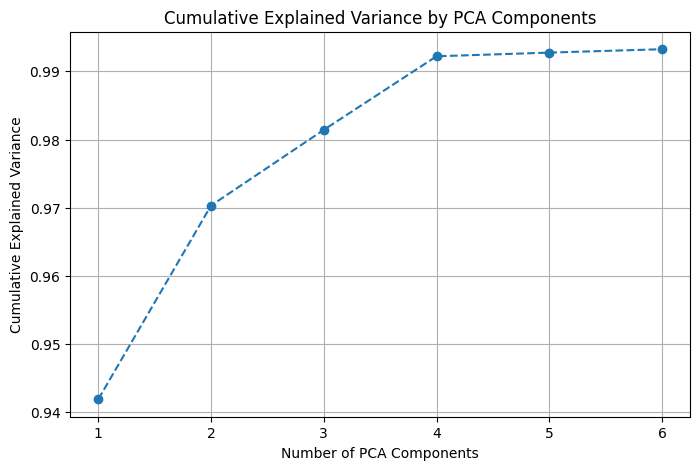

In [184]:
from matplotlib import pyplot as plt


cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [105]:
pca.inverse_transform(data_transformed )

array([[-1.13948881e-17,  2.01474059e-17, -5.66421237e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.73504127e-16,  4.54688754e-17,  2.32834832e-16, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.35091074e-17,  6.70500538e-17,  3.00940839e-16, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-7.56795268e-16, -6.77183418e-17,  1.10307700e-15, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.74850686e-16,  1.64787402e-16,  1.25077278e-15, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.56086147e-16, -1.51358630e-16,  1.52033868e-15, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(data_transformed, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [14]:
svm_linear_liblinear = None
svm_linear_libsvm = None
svm_rbf = None
svm_sgd = None
logistic = None

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm

def do_stats(predictions, actual, model=None):
    print(f'Model: {"Unknown" if model is None else model}')
    print('Accuracy:', accuracy_score(actual, predictions) )
    print('Precision:', precision_score(actual, predictions, average='weighted') )
    print('Recall:', recall_score(actual, predictions, average='weighted') )
    print('F1 Score:', f1_score(actual, predictions, average='weighted') )

In [102]:
# SVM with Linear Kernel using liblinear
svm_linear_liblinear = svm.LinearSVC(dual='auto')
svm_linear_liblinear.fit(X_train, y_train)

LinearSVC(dual='auto')

In [16]:
# SVM with Linear Kernel using libsvm
svm_linear_libsvm = svm.SVC(kernel='linear')
svm_linear_libsvm.fit(X_train, y_train)

In [49]:
# SVM with RBF Kernel
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

SVC()

In [51]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [15]:
from sklearn.linear_model import SGDClassifier

# Linear SVM with SGD Training
svm_sgd = SGDClassifier()
svm_sgd.fit(X_train, y_train)

SGDClassifier()

In [103]:
models = {
    'SVM (Linear - liblinear)': svm_linear_liblinear,
    'SVM (Linear - libsvm)': svm_linear_libsvm,
    'SVM (RBF)': svm_rbf,
    'SVM SGD': svm_sgd,
    'Logistic': logistic
}

In [43]:
import pickle

for model_name, model in models.items():
    if model is not None:
        pickle.dump(model, open(f'model-{model_name}-full-post-pca', 'wb'))

In [104]:
for model_name, model in models.items():
    if model is not None:
        do_stats(y_test, model.predict(X_test), model=model_name)

Model: SVM (Linear - liblinear)
Accuracy: 0.874121944366395
Precision: 0.8752124434560642
Recall: 0.874121944366395
F1 Score: 0.8738709619338041


In [55]:
import time

def inference_time(model, model_name=None):
    timing_ns = 0
    for _ in range(1000):
        sample = data_transformed[np.random.choice(data_transformed.shape[0], 1)[0]]
        start_time = time.time_ns()
        model.predict([sample])
        timing_ns += time.time_ns() - start_time

    print(f'Model: {"Unknown" if model_name is None else model_name}')
    print('NS:', timing_ns / 1000.0)
    print('MS:', timing_ns / (1000.0 * 1000000.0))

In [56]:
for model_name, model in models.items():
    if model is not None:
        inference_time(model, model_name=model_name)

Model: SVM (Linear - liblinear)
NS: 119973.0
MS: 0.119973
Model: SVM (RBF)
NS: 5684844.0
MS: 5.684844
Model: Logistic
NS: 104768.0
MS: 0.104768


In [58]:
len(processed.columns)

298